In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import sys
import fitting_functions as ff
sys.path.append(os.path.join(os.path.abspath(''), '../../')) #This falls into Utilities path
import Lammps.core_functions as cf

# Simultaneous fitting of the energy and pressure for the liquid phase

We are going to polynomial functions of the following shape

$p(x,y) = \sum_{i=n_{min},j=m_{min}}^{n_{max},m_{max}} a_{i,j} f_{1}(i) f_2(j)  x^{f_3(i)} y^{f_4(j)}$ 









For our specific case, we have that the energy is given by 

$\rho e_{exc} = j a_{i,j} \rho^{i} \beta^{j-1}$


Therefore, we see that $x = \rho$, $y = \beta$ 


$f_{1}(i) = 1$ 
$f_{2}(j) = j$ 
$f_{3}(i) = i$ 
$f_{4}(j) = j-1$ 

If we want to express the expressions for $f$ in python using np.polyval, then we will need to write, for example $f_4$ as \[1,-1\] (See polyval documentation).

Now, I can write the energy expression using the class Polynomial, defining the intervals for $i$, and $j$ with the variables deg_x, and deg_y respectively


In [5]:
deg_x = [2,8] 
deg_y = [0,6]
poly_e = ff.Polynomial(deg_x,deg_y,[1],[1,0],[1,0],[1,-1])


# Reference values for the properties at given temperatures and densities
rho_ref = 0 #0.32
beta_ref = 0  #0 1/1.04
p_ref = 0
e_ref = 0
file_p='Published/data_for_rc2.0/liquid/pressure/pressure_liquid_rc2.0.txt' # Temp rho press Sigmapress
file_e='Published/data_for_rc2.0/liquid/energy/energy_liquid_rc2.0.txt'


Same for the pressure, that is given by

$\beta P_{exc} = (i-1) a_{i,j} \rho^{i} \beta^{1}$


In [4]:
poly_p = ff.Polynomial(deg_x,deg_y,[1,-1],[1],[1,0],[1,0])

Lets load the data from simulations

In [6]:
# Pressure
x_p, y_p, z_p, zerr_p = ff.read_data(file_p, p_ref)
x_p = x_p - rho_ref
y_p = y_p - beta_ref

# Energy
x_e, y_e, z_e, zerr_e = ff.read_data(file_e, e_ref)
x_e = x_e - rho_ref
y_e = y_e - beta_ref


Now, lets perform the simultaneous fitting using fit_general which takes as arguments
a list as described in the documentation

In [7]:
help(ff.fit_general)

Help on function fit_general in module fitting_functions:

fit_general(*wrapped_data)
    General fitting that can take any number of polynomials
    
    Args:
        wrapped_data: should contains a list of [data_i]  with data_i = [[x,y,z,zerr],poly]
        where i runs over the number of polynomials



In [8]:
popt, pcov, variables = ff.fit_general([[x_p, y_p, z_p, zerr_p], poly_p],[[x_e,y_e,z_e,zerr_e],poly_e])


Now, we can test how was the fitting for the energy. For that we can use the method evaluate from the Polynomial class that requires the independent variables x,y passed as below and the fitting coefficients (popt)


Created coefficients.dat containing all the fitting coefficients

Created covariant.dat with the covariant matrix of the fitting

Created error.dat containing the relative error between the property and the prediction given by the fitting evaluated at the same input points


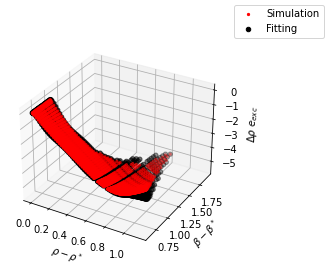

In [10]:
# Computing the predictions
variables_e = np.stack((x_e, y_e),axis=0)
z_e_predicted = poly_e.evaluate(variables_e, popt)

# Computing the error
er_results_e = ff.test_prediction(z_e, z_e_predicted, e_ref)

# Writing the output data
ff.outputs(popt,pcov, er_results_e, deg_x, deg_y,'e')

# Plotting the results
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
ax1.scatter(x_e, y_e, z_e, zdir = 'z',marker ='.', label="Simulation", color ='r')
ax1.scatter(x_e, y_e, z_e_predicted, zdir='z', label="Fitting", color = 'black')
ax1.set_xlabel(r'$\rho-\rho^*$')
ax1.set_ylabel(r'$\beta-\beta^*$')
ax1.set_zlabel(r'$\Delta \rho \ e_{exc}$')

fig1.legend()
fig1.show()
fig1.savefig("3Dplot_e.pdf")

Same for the the pressure



Created coefficients.dat containing all the fitting coefficients

Created covariant.dat with the covariant matrix of the fitting

Created error.dat containing the relative error between the property and the prediction given by the fitting evaluated at the same input points


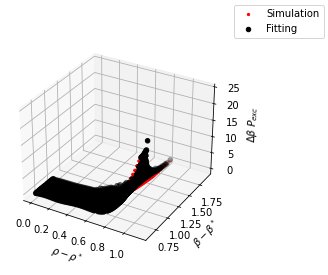

In [11]:
# Computing the predictions
variables_p = np.stack((x_e,y_e),axis=0)
z_p_predicted = poly_p.evaluate(variables_p, popt)

# Computing the error
er_results_p = ff.test_prediction(z_p, z_p_predicted, p_ref)

# Writing the output data
ff.outputs(popt, pcov, er_results_p, deg_x, deg_y, 'p')

# Plotting the results
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')
ax2.scatter(x_p, y_p, z_p, zdir='z',marker='.',label="Simulation", color='r')
ax2.scatter(x_p, y_p, z_p_predicted, zdir='z',label="Fitting", color='black')
ax2.set_xlabel(r'$\rho-\rho^*$')
ax2.set_ylabel(r'$\beta-\beta^*$')
ax2.set_zlabel(r'$\Delta \beta\ P_{exc}$')

fig2.legend()
fig2.show()
fig2.savefig("3Dplot_p.pdf")